## Load Data

In [1]:
import pandas as pd
import json
import re
import pymorphy3
from nltk.corpus import stopwords

In [ ]:

channels = ['readovkanews', 'moscowach', 'moscowmap']

data = []
for file_name in channels:
    with open(f'{file_name}.json', 'r', encoding='utf-8') as file:
        data.extend(json.load(file))
df_titles = pd.DataFrame([{"title": item["title"], "time": item["time"]} for item in data])

comments = []
for i, item in enumerate(data):
    for comment in item["comments"]:
        comments.append({
            "title_number": i + 1,
            "comment": comment["comment"],
            "time": comment["time"]
        })

df_comments = pd.DataFrame(comments)

print("DataFrame с title и time:")
print(len(df_titles))

print("\nDataFrame с комментариями, временем и номером записи:")
print(len(df_comments))
documents = []
count = 0

for _, row in df_titles.iterrows():
    documents.append([count, row["title"], row['time']])
    count += 1
for _, row in df_comments.iterrows():
    documents.append([count, row["comment"], row['time']])
    count += 1

df_docs = pd.DataFrame(documents, columns=['id', 'text', 'time'])

stop_words = stopwords.words('russian')

add_stop_words = '''которых которые твой которой которого сих ком свой твоя этими слишком нами всему будь саму чаще ваше сами наш затем
еще самих наши ту каждое мочь весь этим наша своих оба который зато те этих вся ваш такая теми ею которая нередко
каждая также чему собой самими нем вами ими откуда такие тому та очень сама нему алло оно этому кому тобой таки твоё
каждые твои мой нею самим ваши ваша кем мои однако сразу свое ними всё неё тех хотя всем тобою тебе одной другие
этао само эта буду самой моё своей такое всею будут своего кого свои мог нам особенно её самому наше кроме вообще вон
мною никто это просто ещё'''

add_stop_words = re.sub(r"[^а-я\s]", " ", add_stop_words.replace("ё", "е"))
add_stop_words = add_stop_words.split()

with open('uncensored_words.txt', 'r', encoding='utf-8') as file:
    uncensored_words = file.read()

stop_words.extend(add_stop_words)

morph = pymorphy3.MorphAnalyzer()

def clean_text(text):
    text = text.lower()
    cleaned_text = re.sub(r"[^а-я\s]", " ", text.replace("ё", "е"))
    cleaned_text = re.sub(r"\s+", " ", cleaned_text).strip()
    words = cleaned_text.split()
    # не будем приводить к начальной форме при формировании эмбеддингов и не будем убирать стоп слова, чтобы не ломать семантику
    # words = [morph.parse(word)[0].normal_form for word in words] # начальная форма
    # words = [word for word in words if word not in stop_words] # удаляем стоп слова
    words = [word for word in words if word not in uncensored_words] # удаляем нецензурные слова
    return " ".join(words)

df_docs['clean_text'] = df_docs['text'].apply(clean_text)
df_docs['clean_text'] = df_docs['clean_text'].replace(r'^\s*$', None, regex=True)  # Заменяем пробелы на None
df_docs = df_docs.dropna(subset=['clean_text'])
df_docs['count'] = df_docs['clean_text'].str.split().apply(len)
df_docs = df_docs[df_docs['count'] > 6]
print('Итоговая длина')
print(len(df_docs))

DataFrame с title и time:
904

DataFrame с комментариями, временем и номером записи:
230208
Итоговая длина
113459


# Запускаем отсюда, при наличии готовых данных

In [2]:
df_docs = pd.read_csv('data_try.csv')

In [3]:
df_docs = df_docs.rename(columns={'Document': 'clean_text'})


## Модуль репрезентации

In [4]:
from bertopic.representation._base import BaseRepresentation
from typing import Mapping, List, Tuple
import re
from collections import Counter
import pymorphy3
from nltk.corpus import stopwords

class CustomRepresentationModel(BaseRepresentation):
    def __init__(self, stop_words: List[str]):
        self.stop_words = set(stop_words)
        self.morph = pymorphy3.MorphAnalyzer()
    
    def lemmatize(self, word: str) -> str:
        return self.morph.parse(word)[0].normal_form

    def preprocess(self, text: str) -> List[str]:
        words = re.findall(r'\b\w+\b', text.lower())
        words = [self.lemmatize(word) for word in words if word not in self.stop_words]
        return words
    
    def extract_topics(self, topic_model, documents, c_tf_idf, topics
                      ) -> Mapping[str, List[Tuple[str, float]]]:
        updated_topics = {}
        for topic, words in topics.items():
            processed_words = []
            for word, score in words:
                clean_word = self.lemmatize(word)
                if clean_word not in self.stop_words:
                    processed_words.append((clean_word, score))
            # Объединение одинаковых слов и их баллов
            word_counts = Counter()
            for word, score in processed_words:
                word_counts[word] += score
            updated_topics[topic] = word_counts.most_common()
        return updated_topics
    

stop_words = stopwords.words('russian')

add_stop_words = '''которых которые твой которой которого сих ком свой твоя этими слишком нами всему будь саму чаще ваше сами наш затем
еще самих наши ту каждое мочь весь этим наша своих оба который зато те этих вся ваш такая теми ею которая нередко
каждая также чему собой самими нем вами ими откуда такие тому та очень сама нему алло оно этому кому тобой таки твоё
каждые твои мой нею самим ваши ваша кем мои однако сразу свое ними всё неё тех хотя всем тобою тебе одной другие
этао само эта буду самой моё своей такое всею будут своего кого свои мог нам особенно её самому наше кроме вообще вон
мною никто это просто ещё почему это'''

add_stop_words = add_stop_words.split()
stop_words.extend(add_stop_words)

representation_model = CustomRepresentationModel(stop_words)


e:\PythonProjects\DynamicTopicModeling\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Обучение

In [5]:
from bertopic import BERTopic

topic_model_basic = BERTopic(language="russian", calculate_probabilities=False, verbose=True, representation_model=representation_model)
topics_old, probs_old = topic_model_basic.fit_transform(df_docs['clean_text'])

2025-03-18 16:16:52,518 - BERTopic - Embedding - Transforming documents to embeddings.
Batches: 100%|██████████| 109/109 [00:01<00:00, 55.90it/s] 
2025-03-18 16:16:58,007 - BERTopic - Embedding - Completed ✓
2025-03-18 16:16:58,008 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-03-18 16:17:11,968 - BERTopic - Dimensionality - Completed ✓
2025-03-18 16:17:11,971 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-03-18 16:17:12,082 - BERTopic - Cluster - Completed ✓
2025-03-18 16:17:12,087 - BERTopic - Representation - Extracting topics from clusters using representation models.
2025-03-18 16:17:12,167 - BERTopic - Representation - Completed ✓


In [6]:
freq = topic_model_basic.get_topic_info(); freq.head(30)

,Topic,Count,Name,Representation,Representative_Docs
0,0,918,0_зарплата_работа_платить_работать,"[зарплата, работа, платить, работать, зп, боль...",[платите зп нормальные будут вам работники наз...
1,1,894,1_школа_образование_ребёнок_учитель,"[школа, образование, ребёнок, учитель]",[это печально что нынешнее поколение так ненав...
2,2,855,2_полиция_полицейский_стрелять_закон,"[полиция, полицейский, стрелять, закон]",[какой позор что творится почему обошлись табе...
3,3,813,3_врач_мёд_больница,"[врач, мёд, больница]",[естественная убыль упала пусть кто придумал э...


## Вычисление метрик

In [7]:
import warnings

warnings.filterwarnings('ignore')

import numpy as np
from scipy.spatial.distance import jensenshannon


def count_divergence(model: BERTopic, docs) -> float | None:
    topics_info = model.get_topics()

    # Исключаем тему "-1" (отсев нерелевантных документов)
    topic_ids = [tid for tid in topics_info.keys() if tid != -1]

    if not topic_ids:
        raise ValueError("Не найдено тем для анализа!")

    # 4. Собираем объединённое множество слов из всех тем
    all_words = set()
    for tid in topic_ids:
        for word, score in topics_info[tid]:
            all_words.add(word)
    all_words = sorted(list(all_words))

    # 5. Формируем распределение вероятностей для каждой темы
    # Для каждой темы создаём вектор, где позиции соответствуют словам из all_words,
    # а значения — веса (если слово отсутствует, ставим 0).
    topic_distributions = {}
    for tid in topic_ids:
        words_scores = dict(topics_info[tid])
        vec = np.array([words_scores.get(word, 0.0) for word in all_words], dtype=float)
        # Нормализуем вектор, чтобы сумма была равна 1 (если сумма не равна нулю)
        if vec.sum() != 0:
            vec = vec / vec.sum()
        topic_distributions[tid] = vec

    # 6. Функция для вычисления Jensen-Shannon дивергенции между двумя распределениями
    def js_divergence(p, q):
        return jensenshannon(p, q, base=2)

    # 7. Вычисляем среднюю попарную дивергенцию между темами
    divergences = []
    for i, tid1 in enumerate(topic_ids):
        for tid2 in topic_ids[i+1:]:
            divergence = js_divergence(topic_distributions[tid1], topic_distributions[tid2])
            divergences.append(divergence)

    # Глобальная метрика: средняя попарная дивергенция
    if divergences:
        global_divergence = np.mean(divergences)
        print(f"\nГлобальная (средняя) JS Divergence по всем темам: {global_divergence:.4f}")
        return global_divergence
    else:
        print("Дивергенция не рассчитана, недостаточно тем для сравнения.")
        return None

In [8]:
from bertopic import BERTopic
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import Dictionary

def coherence_all_topics(model, data, batch_size=5000):

    topics = data.Topic.unique()
    documents_per_topic = data.groupby(['Topic'], as_index=False).agg({'Document': ' '.join})

    vectorizer = model.vectorizer_model
    analyzer = vectorizer.build_analyzer()

    tokens_list = []
    for i in range(0, len(documents_per_topic), batch_size):
        batch_docs = documents_per_topic.Document.values[i:i+batch_size]
        cleaned_docs = model._preprocess_text(batch_docs)
        tokens_list.extend(analyzer(doc) for doc in cleaned_docs)

    dictionary = Dictionary(tokens_list)

    corpus = [dictionary.doc2bow(token) for token in tokens_list]

    topic_words = [[words for words, _ in model.get_topic(topic)] for topic in range(len(set(topics)) - 1)]

    # dictionary.filter_extremes(no_below=5, no_above=0.9)

    coherence_model = CoherenceModel(
        topics=topic_words, 
        texts=tokens_list, 
        corpus=corpus,
        dictionary=dictionary, 
        coherence='c_v',
        processes=4,  # Ускоряет расчёт, если у тебя многопоточный процессор
        topn=20  # Ограничивает число слов в топике для анализа
    )

    coherence = coherence_model.get_coherence()

    return coherence

def coherence_single_topic(model, data, topic_id):
    if topic_id not in data.Topic.unique():
        raise ValueError(f"Topic {topic_id} not found in data")
    
    documents = ' '.join(data[data.Topic == topic_id]['Document'])
    cleaned_doc = model._preprocess_text([documents])[0]
    
    vectorizer = model.vectorizer_model
    analyzer = vectorizer.build_analyzer()
    
    tokens = analyzer(cleaned_doc)
    dictionary = Dictionary([tokens])
    corpus = [dictionary.doc2bow(tokens)]
    topic_words = [words for words, _ in model.get_topic(topic_id)]
    
    coherence_model = CoherenceModel(topics=[topic_words], 
                                     texts=[tokens], 
                                     corpus=corpus,
                                     dictionary=dictionary, 
                                     coherence='c_v',processes=4,
                                     topn=20)
    coherence = coherence_model.get_coherence()
    return coherence

## Алгоритм разделения на временные интервалы

Получение документ - тема - вероятность

In [9]:
doc_to_topic = topic_model_basic.get_document_info(df_docs['clean_text'])

doc_to_topic['id'] = range(1, len(doc_to_topic) + 1)
df_docs['id'] = range(1, len(doc_to_topic) + 1)
merged = doc_to_topic.merge(df_docs[['id', 'clean_text', 'time']], how='left', on='id')

res = merged[['id', 'Document', 'time', 'Topic', 'Name','Representation', 'Top_n_words', 'Probability']]
res['time'] = pd.to_datetime(res['time'])
unique_topics = sorted(res['Topic'].unique().tolist())

In [10]:
coherence_all_topics(topic_model_basic, res)

0.711428957230948

Подбираем интервал который максимизирует согласованность в теме

In [73]:
def get_optimal_interval_count_for_topic(topic_data, topic):
    start_date = topic_data["time"].min()
    end_date = topic_data["time"].max()
    
    topic_life = end_date - start_date
    min_docs = 10  # Минимальное количество документов
    best_interval = None
    best_coherence = 0
    print('Topic life:', topic_life.days)
    for interval in range(topic_life.days, 2, -1):
        try:
            print(interval)
            topic_data["interval"] = pd.cut(topic_data["time"], bins=interval)
            counts = topic_data["interval"].value_counts().reset_index()
            counts.columns = ["interval", "count"]
            
            # Проверяем, есть ли интервал с минимум 10 документами
            if counts["count"].min() >= min_docs:
                interval_coherences = []
            
                for interval_label in counts["interval"]:
                    interval_docs = topic_data[topic_data["interval"] == interval_label]
                    coherence = coherence_single_topic(topic_model_basic, interval_docs, topic)
                    interval_coherences.append(coherence)
                
                avg_coherence = sum(interval_coherences) / len(interval_coherences)
                
                if avg_coherence > best_coherence:
                    best_coherence = avg_coherence
                    best_interval = interval
        except Exception as e:
            print('error interval: ', interval, e)
    return best_interval

In [12]:
res['date'] = pd.to_datetime(res['time']).dt.date
topic_intervals = dict()

In [ ]:
for topic in unique_topics:
    # skip noise topic
    if topic in (-1,):
        continue
    cur_res = res[res['Topic'] == topic]

    topic_intervals[topic] = get_optimal_interval_count_for_topic(cur_res, topic)

Topic life: 13
13
12
11
10
9
8
7
6
5
4
3
Topic life: 13
13
12
11
10
9
8
7
6
5
4
3
Topic life: 13
13
12
11
10
9
8
7
6
5
4
3
Topic life: 13
13
12
error interval:  12 unable to interpret topic as either a list of tokens or a list of ids
11
error interval:  11 unable to interpret topic as either a list of tokens or a list of ids
10
9
8
7
6
5
4
3


Алгоритм для поиска точек бифуркации

Сравниваем интервалы друг с другом, есле подходит по условию, то тогда точка бифуркации

На всех документах после запускаем новый Bertopic

## Функция для создания представлений текстов на каждом интервале

In [14]:
from sklearn.preprocessing import normalize
from typing import List, Union, Tuple
from tqdm import tqdm


def topics_over_time_new(
        self,
        docs: List[str],
        timestamps: Union[List[str], List[int]],
        topics: List[int] = None,
        nr_bins: int = None,
        datetime_format: str = None,
        evolution_tuning: bool = True,
        global_tuning: bool = True,
    ) -> pd.DataFrame:
        
        selected_topics = topics
        documents = pd.DataFrame({"Document": docs, "Topic": selected_topics, "Timestamps": timestamps})
        global_c_tf_idf = normalize(self.c_tf_idf_, axis=1, norm="l1", copy=False)

        all_topics = sorted(list(documents.Topic.unique()))
        all_topics_indices = {topic: index for index, topic in enumerate(all_topics)}

        if isinstance(timestamps[0], str):
            infer_datetime_format = True if not datetime_format else False
            documents["Timestamps"] = pd.to_datetime(
                documents["Timestamps"],
                infer_datetime_format=infer_datetime_format,
                format=datetime_format,
            )
        if nr_bins:
            documents["Bins"] = pd.cut(documents.Timestamps, bins=nr_bins)
            documents["Timestamps"] = documents.apply(lambda row: row.Bins.left, 1)

        # Sort documents in chronological order
        documents = documents.sort_values("Timestamps")
        timestamps = documents.Timestamps.unique()

        # For each unique timestamp, create topic representations
        topics_over_time = []
        for index, timestamp in tqdm(enumerate(timestamps), disable=True):
            # Calculate c-TF-IDF representation for a specific timestamp
            selection = documents.loc[documents.Timestamps == timestamp, :]
            documents_per_topic = selection.groupby(["Topic"], as_index=False).agg(
                {"Document": " ".join, "Timestamps": "count"}
            )
            c_tf_idf, words = self._c_tf_idf(documents_per_topic, fit=False)

            if global_tuning or evolution_tuning:
                c_tf_idf = normalize(c_tf_idf, axis=1, norm="l1", copy=False)

            # Fine-tune the c-TF-IDF matrix at timestamp t by averaging it with the c-TF-IDF
            # matrix at timestamp t-1
            if evolution_tuning and index != 0:
                current_topics = sorted(list(documents_per_topic.Topic.values))
                overlapping_topics = sorted(
                    list(set(previous_topics).intersection(set(current_topics)))  # noqa: F821
                )

                current_overlap_idx = [current_topics.index(topic) for topic in overlapping_topics]
                previous_overlap_idx = [
                    previous_topics.index(topic)  # noqa: F821
                    for topic in overlapping_topics
                ]

                c_tf_idf.tolil()[current_overlap_idx] = (
                    (
                        c_tf_idf[current_overlap_idx] + previous_c_tf_idf[previous_overlap_idx]  # noqa: F821
                    )
                    / 2.0
                ).tolil()

            # Fine-tune the timestamp c-TF-IDF representation based on the global c-TF-IDF representation
            # by simply taking the average of the two
            if global_tuning:
                selected_topics = [all_topics_indices[topic] for topic in documents_per_topic.Topic.values]
                c_tf_idf = (global_c_tf_idf[selected_topics] + c_tf_idf) / 2.0

            # Extract the words per topic
            words_per_topic = self._extract_words_per_topic(words, selection, c_tf_idf, calculate_aspects=False)
            topic_frequency = pd.Series(
                documents_per_topic.Timestamps.values, index=documents_per_topic.Topic
            ).to_dict()

            # Fill dataframe with results
            topics_at_timestamp = [
                (
                    topic,
                    [words[0] for words in values][:5],
                    topic_frequency[topic],
                    timestamp,
                    selection[selection.Topic == topic].Document.to_list(),
                )
                for topic, values in words_per_topic.items()
            ]
            topics_over_time.extend(topics_at_timestamp)

            if evolution_tuning:
                previous_topics = sorted(list(documents_per_topic.Topic.values))  # noqa: F841
                previous_c_tf_idf = c_tf_idf.copy()  # noqa: F841

        topics_over_time = pd.DataFrame(topics_over_time, columns=["Topic", "Words", "Frequency", "Timestamp", "Document"])
        topics_over_time['TimestampID'] = pd.factorize(topics_over_time['Timestamp'])[0] + 1
        return topics_over_time

## Функция ветвления для каждой темы

In [16]:
def count_similirity(words1: list[str], words2: list[str]):
    count = 0
    for i in words1:
        for j in words2:
            if i == j:
                count += 1
    return count

In [17]:
class Branch:
    _next_id = 1
    
    def __init__(self, df: pd.DataFrame, start_interval: int, end_interval: int = None):
        self.df = df
        self.id = Branch._next_id
        self.start_interval = start_interval
        self.end_interval = end_interval
        Branch._next_id += 1

    def __hash__(self):
        return self.id
    
    def get_representation(self):
        return ' '.join(self.df['Words'].iloc[0])
    
    def __repr__(self):
        words = self.get_representation()
        return f"{self.start_interval}->{self.end_interval or 'None'} {words}"

In [ ]:
from umap import UMAP

def find_bifurcation_point(intervals: pd.DataFrame, exp_intervals, prev_interval_id=0) -> Tuple[Branch, List[Branch]] | Tuple[Branch, List]:
    before_bifurc = []
    cur_inter = intervals.iloc[0]
    start_interval_id = cur_inter['TimestampID']
    for i in range(1, len(intervals)):
        prev_inter = intervals.iloc[i - 1]
        cur_inter = intervals.iloc[i]
        
        prev_docs = exp_intervals[exp_intervals['Timestamp'] == prev_inter['Timestamp']]
        before_bifurc.append(prev_docs)

        if count_similirity(prev_inter.Words, cur_inter.Words) < 3:
            # Main branch
            main_branch = Branch(pd.concat(before_bifurc), start_interval_id + prev_interval_id, prev_inter['TimestampID'] + prev_interval_id)

            documents_for_new_train = exp_intervals[exp_intervals['Timestamp'] >= cur_inter['Timestamp']]
            documents_for_new_train = documents_for_new_train.drop('Topic', axis=1)

            if len(documents_for_new_train) < 3: # минимальное кол-во документов для работы 3 из-за особенностей Bertopic
                return main_branch, []

            if 3 <= len(documents_for_new_train) < 10:
                # Строим разветвление
                umap_model = UMAP(
                    n_neighbors=15,
                    n_components=max(1, len(documents_for_new_train) // 2), # n_components - размерность зависит от кол-ва документов
                    min_dist=0.0,
                    metric="cosine",
                )
                new_model = BERTopic(umap_model=umap_model, language="russian", calculate_probabilities=False, min_topic_size=3, verbose=False, representation_model=representation_model)
            else:
                new_model = BERTopic(language="russian", calculate_probabilities=False, verbose=False, representation_model=representation_model)

            topics, probs = new_model.fit_transform(documents_for_new_train.Document)

            doc_to_topic = new_model.get_document_info(documents_for_new_train.Document)
            doc_to_topic['id'] = range(1, len(doc_to_topic) + 1)
            merged = doc_to_topic.merge(documents_for_new_train, how='left', on='Document')
            new_data = merged[['Timestamp', 'Document', 'Topic']]
            

            # Если только мусорная тема, то берём её за ветку
            if len(new_data.Topic.unique()) == 1:
                cur_topic = new_data[new_data.Topic == -1]
                repr = topics_over_time_new(new_model,
                                        cur_topic['Document'].to_list(),
                                        cur_topic['Timestamp'].to_list(),
                                        topics=cur_topic['Topic'].to_list())
                return main_branch, [Branch(repr, cur_inter['TimestampID'] + prev_interval_id)]
            
            list_branches = []
            for i in new_data.Topic.unique().tolist():
                cur_topic = new_data[new_data.Topic == i]
                repr = topics_over_time_new(new_model,
                                        cur_topic['Document'].to_list(),
                                        cur_topic['Timestamp'].to_list(),
                                        topics=cur_topic['Topic'].to_list())
                list_branches.append(Branch(repr, cur_inter['TimestampID'] + prev_interval_id))
            
            return main_branch, list_branches
        
    cur_doc = exp_intervals[exp_intervals['Timestamp'] == cur_inter['Timestamp']]
    before_bifurc.append(cur_doc)
    return Branch(pd.concat(before_bifurc), start_interval_id + prev_interval_id, cur_inter['TimestampID'] + prev_interval_id), []


def create_branches_for_topic(res, topic):
    structure = dict()

    topic_doc = res[res['Topic'] == topic]
    interval = topic_intervals[topic]

    topics_over_time = topics_over_time_new(topic_model_basic,
                                        topic_doc['Document'].to_list(),
                                        topic_doc['time'].to_list(),
                                        topics=topic_doc['Topic'].to_list(),
                                        nr_bins=interval)
    intervals = topics_over_time.sort_values('Timestamp')
    exp_intervals = intervals.explode('Document')

    stack = []
    
    main_branch, new_branches = find_bifurcation_point(intervals, exp_intervals)

    structure[main_branch] = new_branches
    print(structure)

    if new_branches is not None:
        stack.extend(new_branches)

    while stack:
        branch: Branch = stack.pop()

        branch_topics_over_time = branch.df
        branch_inter = branch_topics_over_time.sort_values('Timestamp')
        branch_exp_intervals = branch_inter.explode('Document')

        print(branch.start_interval)
        main_branch, new_branches = find_bifurcation_point(branch_inter, branch_exp_intervals, branch.start_interval - 1)

        # Clean
        for key, value in structure.items():
            if isinstance(value, list):
                structure[key] = [main_branch if x == branch else x for x in value]
            elif value == branch:
                structure[key] = main_branch

        structure[main_branch] = new_branches

        if new_branches is None:
            continue
        
        if len(new_branches) == 1 and new_branches[0].df['Topic'].unique() == [-1]:
            append_branch = new_branches[0]
            append_branch.end_interval = interval
            # Clean
            for key, value in structure.items():
                if isinstance(value, list):
                    structure[key] = [append_branch if x == new_branches[0] else x for x in value]
                elif value == new_branches[0]:
                    structure[key] = append_branch

            structure[append_branch] = []

            print('end_line')
            continue

        if new_branches is not None:
            stack.extend(new_branches)
            
    return structure

In [67]:
structure_topic = {}
for topic in unique_topics:
    structure_topic[topic] = create_branches_for_topic(res, topic)

{1->7 работа зарплата работать начальник большой: [8->None зарплата работать человек зп месяц, 8->None зарплата средний зп человек москва, 8->None работать работа зарплата платить работодатель, 8->None работа работать пускай значит человек, 8->None снизить издержка большой использовать ресурс]}
8
end_line
8
end_line
8
end_line
8
8
9
9
9
{1->1 школа зарплата зп работать большой: [2->None указ начинаться делаться работа больший, 2->None образование школа поколение студентка ребёнок, 2->None развиваться очный лёгкий уверенный заочный, 2->None шок бред пробовать книжка зомбировать, 2->None сад детский ребёнок университет хотеть, 2->None безответственный больница инфантильный мучить защищать, 2->None диплом человек образование деятельность лицензия, 2->None дошкольный бесплатный предоставлять урок ребёнок, 2->None метод бездарь знание повезти мужчина, 2->None второе крыша висеть первый обрабатывать, 2->None ум вымысел поразить постичь практический, 2->None здание кремль родить км новый, 2->

### Алгоритм очистки от повторяющихся вершин (не используется в связи с применением прямо в модели построения)

In [27]:
from collections import defaultdict

def replace_none_branches(adjacency_dict):
    # Группируем ветки по start_interval и словам
    groups = defaultdict(list)
    for branch in adjacency_dict.keys():
        words_str = ' '.join(branch.df['Words'].iloc[0])
        key = (branch.start_interval, words_str)
        groups[key].append(branch)
    
    # Создаём карту замен: None-ветка -> соответствующая не-None ветка
    replace_map = {}
    for key in groups:
        branches = groups[key]
        non_none_branches = [b for b in branches if b.end_interval is not None]
        none_branches = [b for b in branches if b.end_interval is None]
        
        if non_none_branches:
            replacement = non_none_branches[0]
            for none_branch in none_branches:
                replace_map[none_branch] = replacement
    
    # Обновляем граф, удаляя ссылки на себя
    new_adjacency_dict = defaultdict(list)
    for branch, children in adjacency_dict.items():
        current_branch = replace_map.get(branch, branch)
        new_children = [
            replace_map.get(child, child) 
            for child in children 
            if child != branch  # Игнорируем ссылки на себя до замены
        ]
        # Дополнительная проверка после замены
        new_children = [child for child in new_children if child != current_branch]
        new_adjacency_dict[current_branch].extend(new_children)
    
    # Удаляем дубликаты и пустые списки
    final_adjacency_dict = {}
    for branch, children in new_adjacency_dict.items():
        unique_children = list(set(children))
        if unique_children:
            final_adjacency_dict[branch] = unique_children
        else:
            final_adjacency_dict[branch] = []
    
    return final_adjacency_dict

In [40]:
clean = replace_none_branches(structure_topic2[0])

In [41]:
clean

{1->7 работа зарплата работать начальник большой: [8->8 работа работать пускай значит человек,
  8->8 зарплата зп снизить хватать переработка,
  8->8 работа зарплата работать платить работодатель,
  8->8 зарплата средний человек зп москва,
  8->9 зарплата работать москва большой тыс],
 8->8 работа работать пускай значит человек: [9->9 хотеть работать зп нужно туда],
 9->9 хотеть работать зп нужно туда: [],
 8->8 зарплата зп снизить хватать переработка: [9->9 завод зарплата платить большой зп],
 9->9 завод зарплата платить большой зп: [],
 8->8 работа зарплата работать платить работодатель: [9->9 человек платить работать место идти],
 9->9 человек платить работать место идти: [],
 8->8 зарплата средний человек зп москва: [],
 8->9 зарплата работать москва большой тыс: []}

## Построение графа связей 

In [69]:
def contruct_graph(struct, interval):
    days_to_nodes = [[] for _ in range(interval + 1)]
    new_entries = {}

    for key, value_list in struct.items():
        prev_node = key
        df = prev_node.df
        start_interval = prev_node.start_interval
        original_values = value_list.copy()
        
        days_to_nodes[start_interval].append(prev_node)
        current_chain = [prev_node]

        # Строим временную цепочку
        for i in range(df['TimestampID'].min() + 1, df['TimestampID'].max() + 1):
            cur_df = df[df['TimestampID'] == i]
            cur_node = Branch(cur_df, start_interval + i - 1, start_interval + i)
            
            current_chain.append(cur_node)
            days_to_nodes[cur_node.start_interval].append(cur_node)

        for i in range(len(current_chain)-1):
            new_entries[current_chain[i]] = [current_chain[i+1]]
        
        new_entries[current_chain[-1]] = original_values

    struct.clear()
    struct.update(new_entries)
    return struct, days_to_nodes

In [70]:
global_graphs = {}

for topic in unique_topics:
    interval = topic_intervals[topic]
    global_graphs[topic] = contruct_graph(structure_topic[topic], interval)

## Визуализация 

In [74]:
import matplotlib.pyplot as plt
import networkx as nx

def plot_graph(adj_list, vertices_per_day):
    """
    adj_list: dict, где ключ - вершина, значение - список смежных вершин.
    vertices_per_day: список списков, где каждый подсписок содержит вершины, принадлежащие конкретному дню.
    """
    G = nx.DiGraph()

    # Добавляем все вершины и рёбра в граф
    for node, neighbors in adj_list.items():
        for neighbor in neighbors:
            G.add_edge(node, neighbor)

    # Количество дней
    num_days = len(vertices_per_day)

    # Создаем позиционирование вершин для отрисовки
    pos = {}
    for day_idx, vertices in enumerate(vertices_per_day):
        for v_idx, vertex in enumerate(vertices):
            pos[vertex] = (day_idx, -v_idx)  # (день, индекс по вертикали)

    # Отрисовка
    plt.figure(figsize=(80, 20))

    # Рисуем рёбра только между вершинами из смежных дней
    for day_idx in range(num_days - 1):
        current_day = vertices_per_day[day_idx]
        next_day = vertices_per_day[day_idx + 1]
        edges_to_draw = [(u, v) for u, v in G.edges if u in current_day and v in next_day]
        nx.draw_networkx_edges(G, pos, edgelist=edges_to_draw, edge_color='black', arrows=True)

    # Рисуем вершины для каждого дня
    colors = [f'C{i}' for i in range(num_days)]
    for day_idx, vertices in enumerate(vertices_per_day):
        nx.draw_networkx_nodes(G, pos, nodelist=vertices, node_color=colors[day_idx], label=f'Day {day_idx + 1}')
        nx.draw_networkx_labels(G, pos, labels={v: v for v in vertices})

    plt.title("Граф событий с очередностью по дням")
    plt.axis('off')
    plt.legend()
    plt.show()

struct, days_to_nodes = global_graphs[1]

adjacency_list = struct

{
    'A': ['B'],
    'A4': ['B', 'C'],
    'B': ['D'],
    'C': ['D'],
    'D': ['F'],
    'E': ['F'],
    'F': ['A1', 'A2'],
    'A1': ['B2', 'B3'],
    'A2': ['B1', 'B2'],
    'B1': [],
    'B2': [],
    'B3': []
}

vertices_by_day = days_to_nodes

[
    ['A', 'A4'],  # День 1
    ['B', 'C'],  # День 2
    ['D', 'E'],  # День 3
    ['F'],  # День 4,
    ['A1', 'A2'],
    ['B1', 'B2', 'B3']
]

[['A', 'A4'], ['B', 'C'], ['D', 'E'], ['F'], ['A1', 'A2'], ['B1', 'B2', 'B3']]

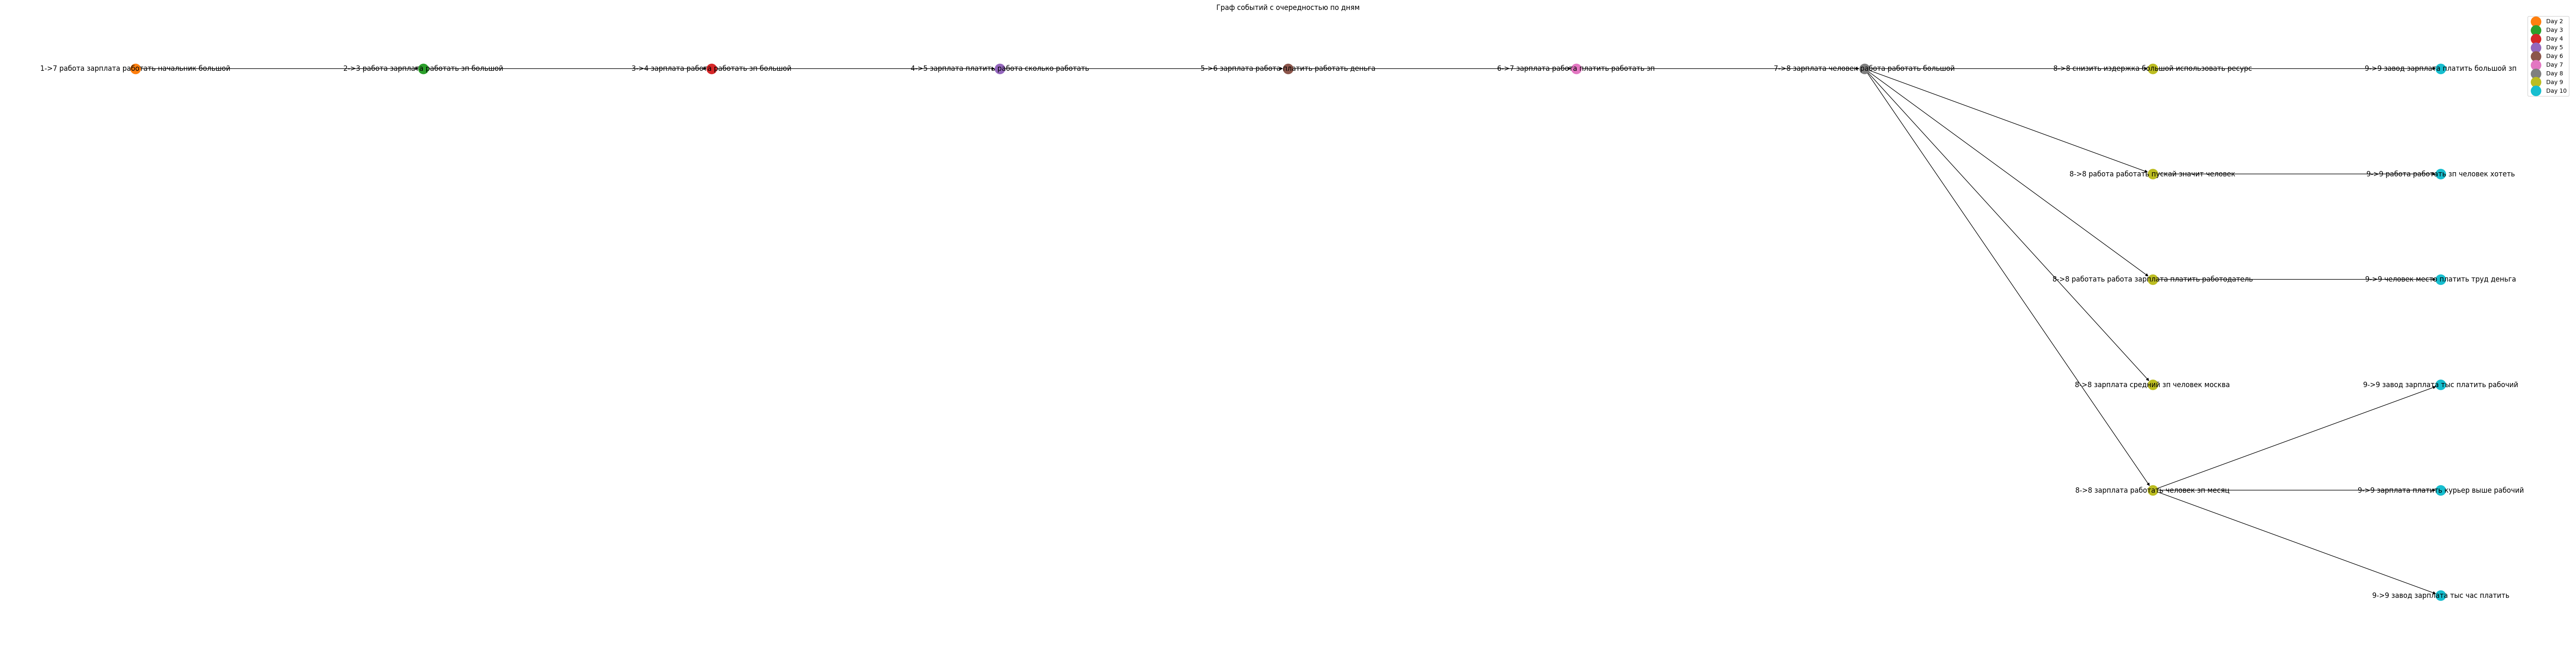

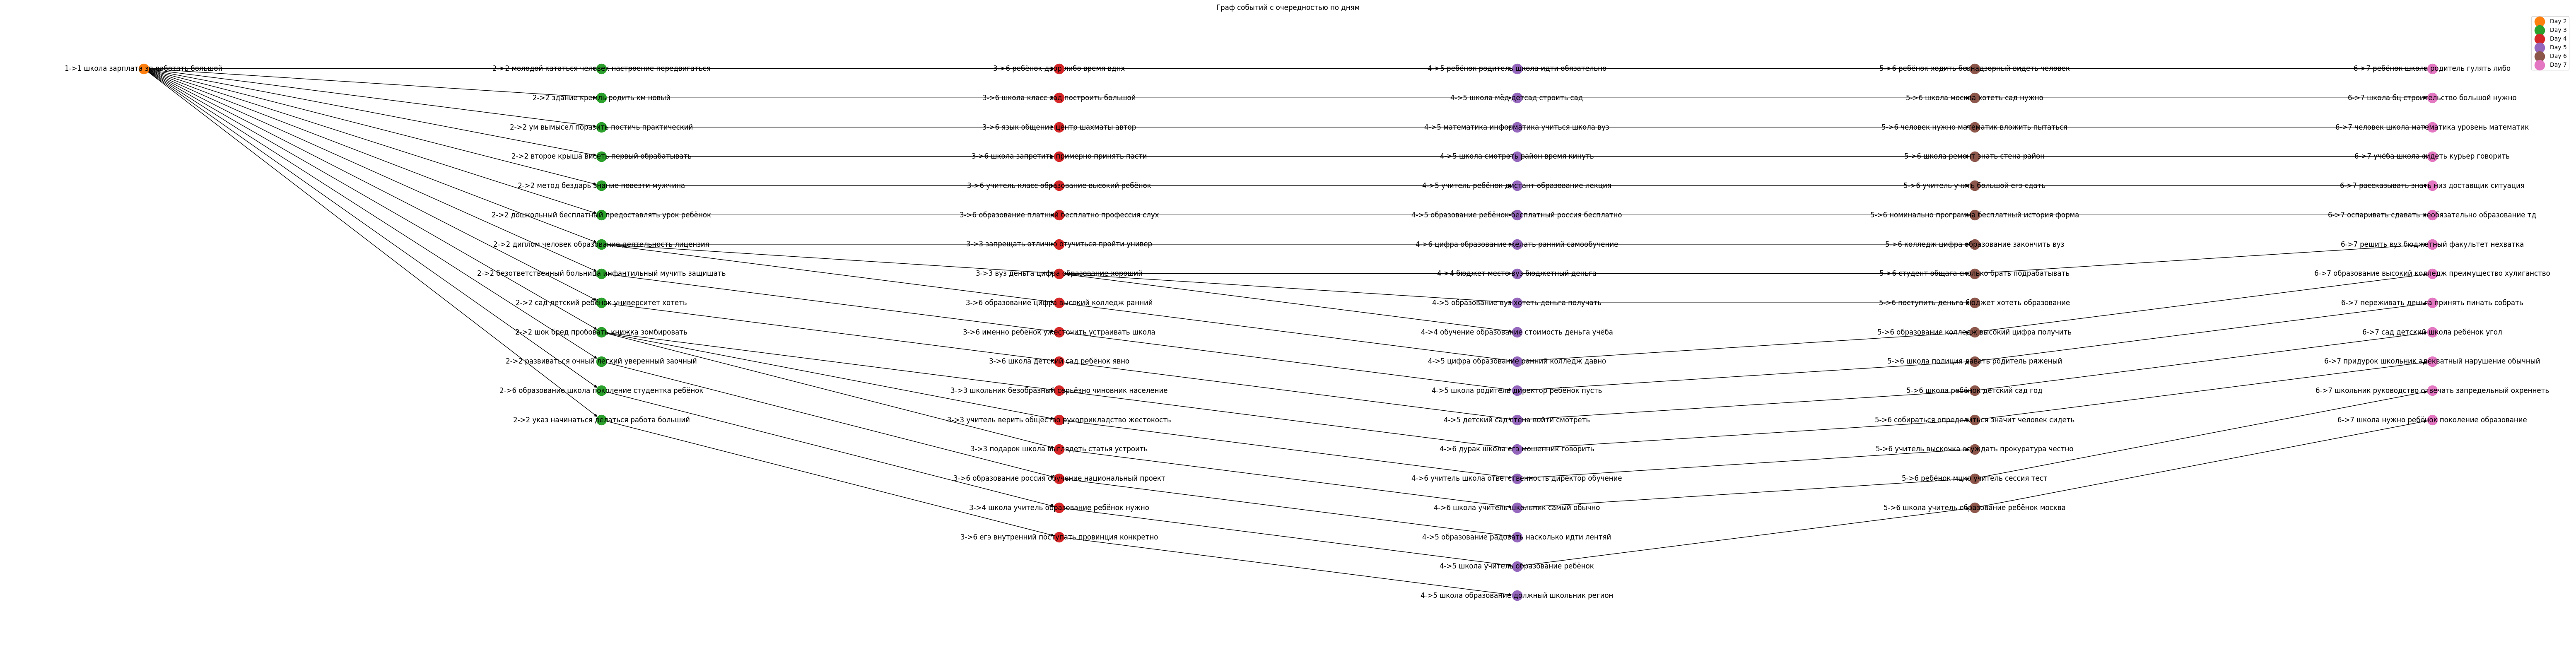

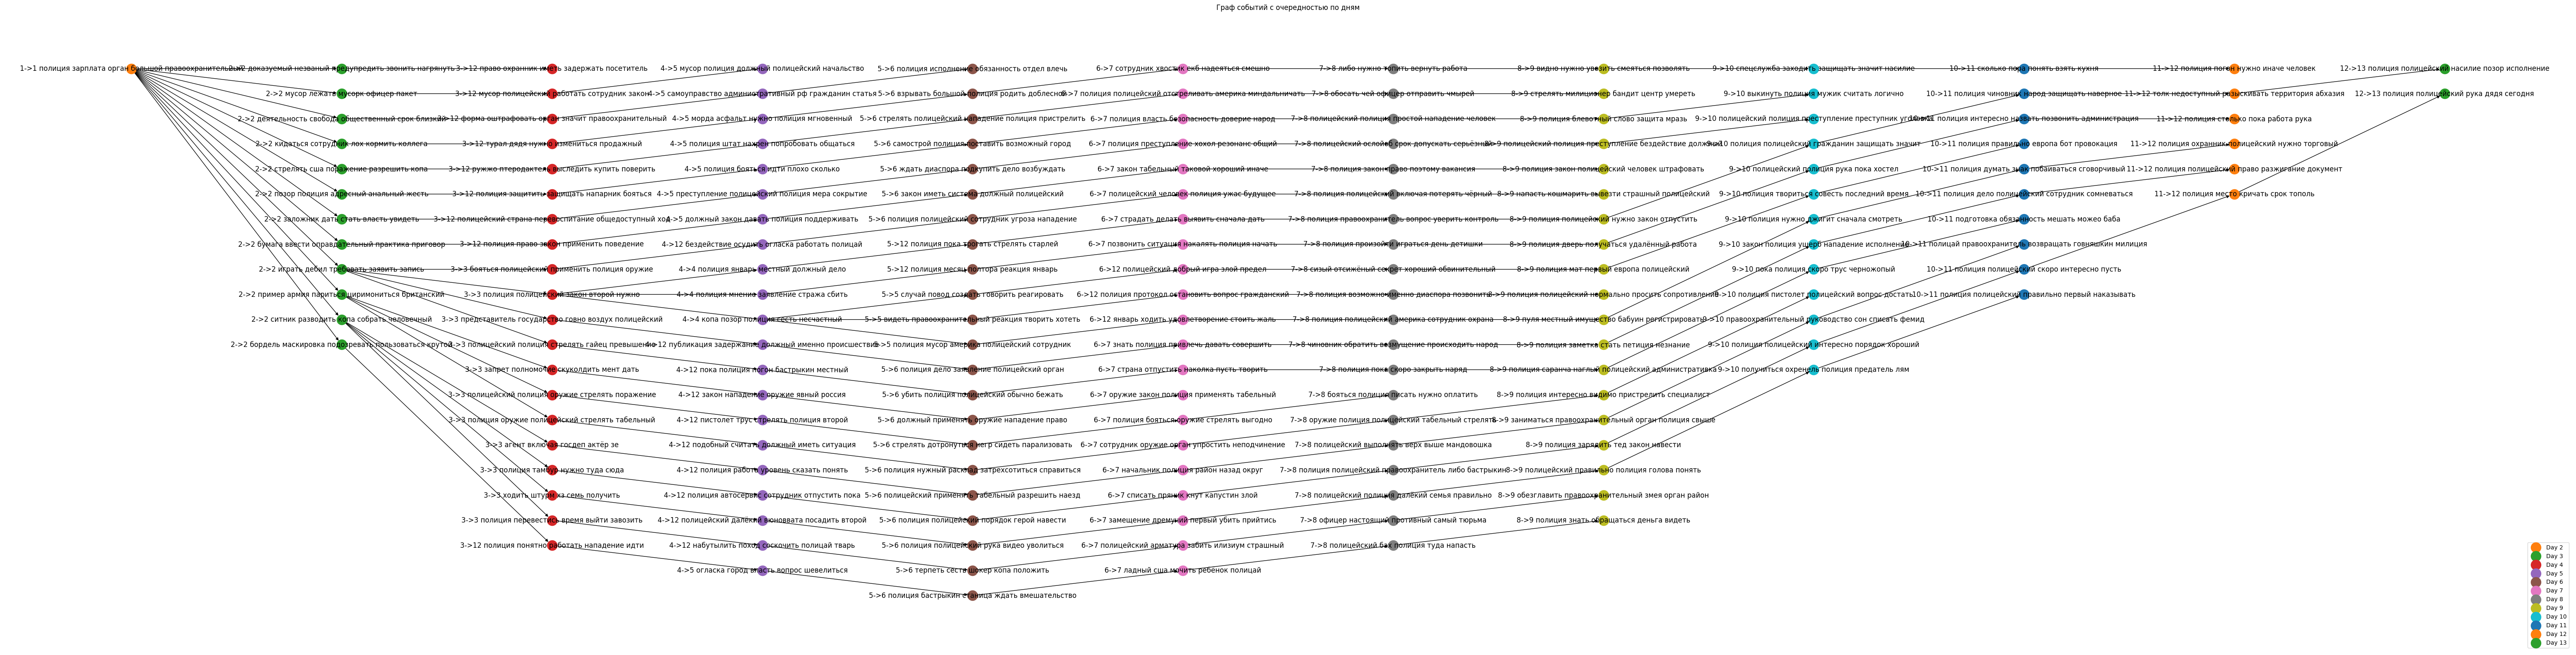

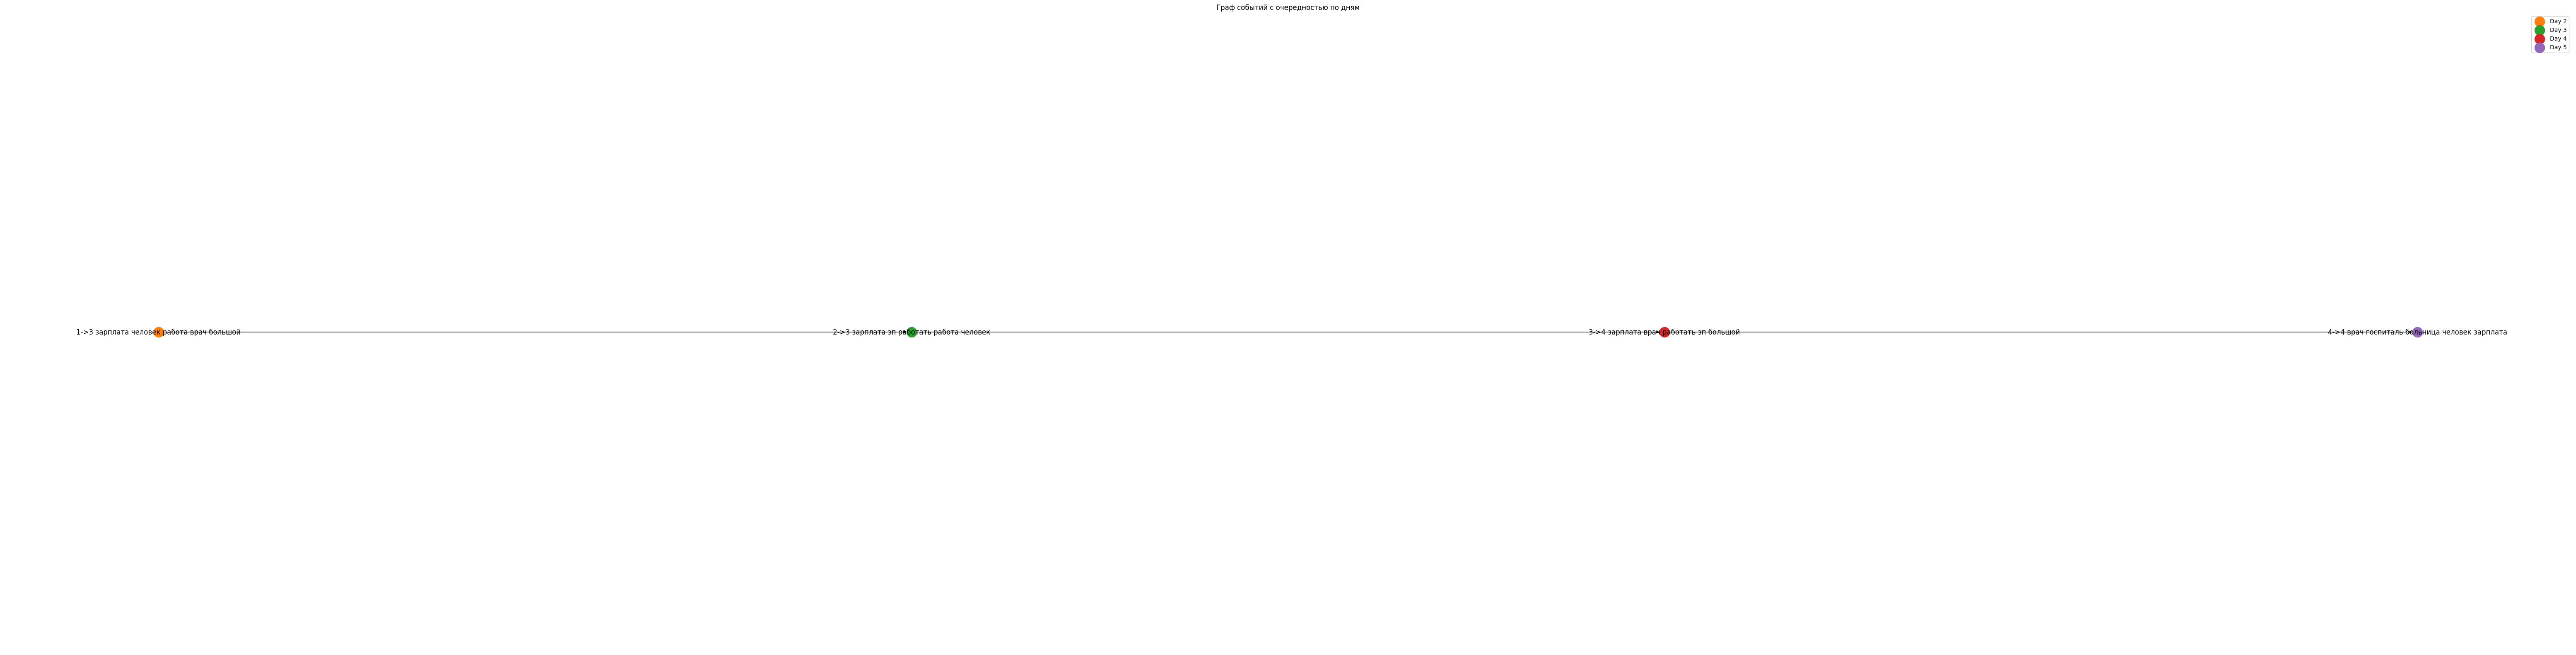

In [76]:
for topic in unique_topics:
    struct, days_to_nodes = global_graphs[topic]
    plot_graph(struct, days_to_nodes)